# Import Data

In [ ]:
import pandas as pd
import numpy as np
url = 'https://drive.google.com/file/d/1g3l-5eGEFN7wcLW1MAQC2AMKZfi89Cu8/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

In [ ]:
df = df.bfill().ffill()
df.head()

,code,Date,roe,mkt_cap,roa,roic,pe,esg_rating,RRR,E_Percentage,S_Percentage,G_Percentage
0,000001.SZ,2015-01-01,4.2062,1809.703334,0.2507,0.5169,8.276713,5,4,0.0,0.0,1.0
1,000001.SZ,2015-01-02,4.2062,1809.703334,0.2507,0.5169,8.276713,5,4,0.0,0.0,1.0
2,000001.SZ,2015-01-03,4.2062,1809.703334,0.2507,0.5169,8.276713,5,4,0.0,0.0,1.0
3,000001.SZ,2015-01-04,4.2062,1809.703334,0.2507,0.5169,8.276713,5,4,0.0,0.0,1.0
4,000001.SZ,2015-01-05,4.2062,1830.268145,0.2507,0.5169,8.370767,5,4,0.0,0.0,1.0


# ESG Rating Distribution and Correlation


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

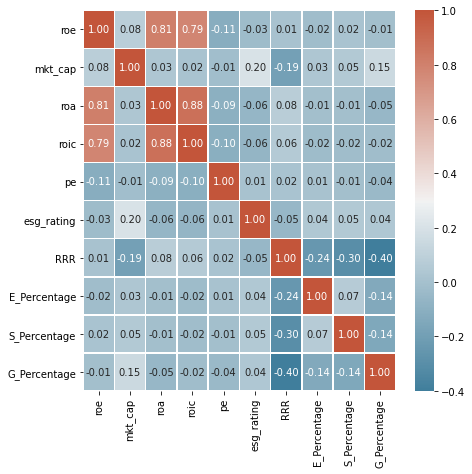

In [ ]:
corr = df.drop(columns = ['code','Date']).corr()
cmap = sns.diverging_palette(230, 20,  as_cmap=True)
plt.figure(figsize=(7,7))
sns.heatmap(corr, cmap = cmap,annot=True,fmt='.2f',linewidth=0.5,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
# df_2015.groupby([pd.Grouper(key='Date_2015', freq='MS')])['roic_2015'].sum()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


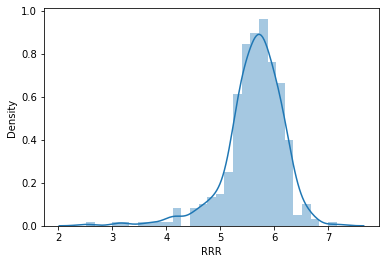

In [ ]:
rrr_mean = df.set_index('Date').groupby('code').mean()['RRR']
sns.distplot(rrr_mean)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


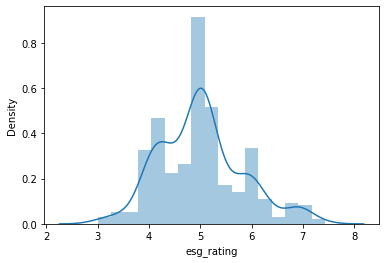

In [ ]:
st_mean = df.set_index('Date').groupby('code').mean()['esg_rating']
sns.distplot(st_mean)

In [ ]:
rrr_label = pd.qcut(df.groupby('code').mean()['RRR'].sort_values(),q=3,labels=['low','medium','high'])
quant_rrr = []
for i in df.code:
  quant_rrr.append(rrr_label[i])
df['quant_rrr'] = quant_rrr

In [ ]:
url = 'https://drive.google.com/file/d/1g3l-5eGEFN7wcLW1MAQC2AMKZfi89Cu8/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df_raw = pd.read_csv(path)
rrr_label = pd.qcut(df_raw.groupby('code').mean()['RRR'].sort_values(),q=3,labels=['low','medium','high'])
quant_rrr = []
for i in df_raw.code:
  quant_rrr.append(rrr_label[i])
df_raw['quant_rrr'] = quant_rrr

# Machine learning prediction

In [ ]:
df_2015 = df[(df['Date']>='2015-01-01') & (df['Date']<'2016-01-01')].set_index('code')
df_2016 = df[(df['Date']>='2016-01-01') & (df['Date']<'2017-01-01')].set_index('code')
df_2017 = df[(df['Date']>='2017-01-01') & (df['Date']<'2018-01-01')].set_index('code')
df_2018 = df[(df['Date']>='2018-01-01') & (df['Date']<'2019-01-01')].set_index('code')
df_2019 = df[(df['Date']>='2019-01-01') & (df['Date']<'2020-01-01')].set_index('code')
df_2020 = df[(df['Date']>='2020-01-01') & (df['Date']<'2021-01-01')].set_index('code')
for i in range(6):
  cur = [df_2015,df_2016,df_2017,df_2018,df_2019,df_2020][i]
  tmp = cur.columns
  cur.columns = ['Date'] + [item+'_'+str(2015+i) for item in tmp[1:]]
  cur['Date'] = pd.to_datetime(cur['Date'])

In [ ]:
code = list(set(df_2015.index))
X = pd.DataFrame()
for i in code:
  tmp = df_2015.loc[i,:].resample('QS',on = 'Date')['roic_2015','esg_rating_2015'].mean()
  X = X.append(tmp,ignore_index=True)
y = pd.Series()
for i in code:
  tmp = df_2020.loc[i,:].resample('QS', on= 'Date')['roic_2020'].mean()
  y = y.append(tmp,ignore_index=True)
y = pd.Series.to_frame(y)
full = X.join(y).dropna()
full.columns = ['past_cfp','past_esg','future_cfp']

X = full[['past_cfp','past_esg']]
y =  full[['future_cfp']]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train = np.sign(y_train['future_cfp'] - X_train['past_cfp']).astype(int)
y_test = np.sign(y_test['future_cfp'] - X_test['past_cfp']).astype(int)

In [ ]:
ls = LogisticRegression()
ls.fit(X_train[['past_cfp']], y_train)
y_pred = ls.predict(X_test[['past_cfp']])
print('Prediction accuracy WITHOUT ESG rating as input is: {}'.format(accuracy_score(y_test, y_pred)))

Prediction accuracy WITHOUT ESG rating as input is: 0.6392405063291139


In [ ]:
ls = LogisticRegression()
ls.fit(X_train[['past_cfp']], y_train)
y_pred = ls.predict(X_test[['past_cfp', 'RRR']])
print('Prediction accuracy with ESG rating as input is: {}'.format(accuracy_score(y_test, y_pred)))